#Automatic stepwise linear regression in python

## Uploading a data.csv file

In order to perform the analysis, the first thing we need is a file containing some data. 
Therefore, the first step here is to upload a file, if possible named "data.csv", and with the following format. (Note that you can add as many variables as you wish, but the result should always be the last column. Inserting spaces after the separating commas is ok, but please avoid tabulations).

>data.csv (example):
>>var_a, &nbsp;&nbsp;&nbsp;var_b, &nbsp;&nbsp;&nbsp;var_c, &nbsp;&nbsp;&nbsp;result<br>
>>1, &nbsp;&nbsp;&nbsp;5, &nbsp;&nbsp;&nbsp;7, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.11<br>
>>2, &nbsp;&nbsp;&nbsp;6, &nbsp;&nbsp;&nbsp;4, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.21<br>
>>3, &nbsp;&nbsp;&nbsp;7, &nbsp;&nbsp;&nbsp;12, &nbsp;&nbsp;&nbsp;8.13<br>
>>4, &nbsp;&nbsp;&nbsp;8, &nbsp;&nbsp;&nbsp;8, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;8.45<br>
>>5, &nbsp;&nbsp;&nbsp;9, &nbsp;&nbsp;&nbsp;13, &nbsp;&nbsp;&nbsp;10.73<br>
>>6, &nbsp;&nbsp;&nbsp;10, &nbsp;&nbsp;&nbsp;2, &nbsp;&nbsp;&nbsp;12.87<br>
>>7, &nbsp;&nbsp;&nbsp;11, &nbsp;&nbsp;&nbsp;19, &nbsp;&nbsp;14.32<br>
>>8, &nbsp;&nbsp;&nbsp;12, &nbsp;&nbsp;&nbsp;5, &nbsp;&nbsp;&nbsp;15.19<br>
>>9, &nbsp;&nbsp;&nbsp;13, &nbsp;&nbsp;&nbsp;9, &nbsp;&nbsp;&nbsp;16.78<br>
>>7, &nbsp;&nbsp;&nbsp;9, &nbsp;&nbsp;&nbsp;3, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;12.21<br>

<br>

## Installing the required modules

Then, before we really get started with the analysis, let's check that all the required modules are already installed.

In [ ]:
!pip install numpy scipy matplotlib pandas lmfit termcolor
!echo "ok"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ok


## Importing modules

If everything is ok, let's now import the required modules.

In [ ]:
import numpy
import pandas
from lmfit import Model, Parameters
from scipy.stats import f as stats_f
import matplotlib as mpl
import matplotlib.pyplot as plt
from termcolor import colored


## Define the main options

In the original python script, these used to be command-line arguments parsed by the argparse module. 

In order to keep the same structure, let's create a dummy object called "args", that will contain the value of the arguments passed to the rest of the script.

The effect of these arguments is the following :

>data_file (default: "data.csv")
>> --> file to be used for the analysis<br>
>> ex: "my_filename.csv"

<br>

>name_delimiter (default: "\_\_\_")
>> --> delimiter used to build var names<br>
>> (please change it if one of your variables must have \"\_\_\_\" in its name)<br>
>>(note: most special characters won't work...)

<br>

>with_interactions (`True` or `False`, default: `False`)
>> --> include interactions between variables when building the equation of the model<br>
>> (ex: K + A * x + B * y + C * (x * y) )

<br>

>with_second_order (`True` or `False`, default: `False`)
>> --> include second order variables when building the equation of the model<br>
>> (ex: K + A * x + B * y + L * (x^2) + M * (y^2) )

<br>

>forward_first (`True` or `False`, default: `False`)
>> --> start with all parameters deactivated, then run forward & backward selections, until the selection is stable.<br>
>> (the default behavior is to start with a backward selection on all parameters).

<br>

>once_only (`True` or `False`, default: `False`)
>> --> only run the (chosen) selection once.<br>
>> (The default behavior without this option is to run backward & forward selections until the selection doesn't change anymore).

In [ ]:
class Dummy_args():
  pass

args = Dummy_args()

args.data_file = "data.csv"
args.name_delimiter = "___"
args.with_interactions = True
args.with_second_order = False
args.polynomial_degree = 3
args.once_only = False
args.forward_first = False
args.normalize = False

args.min_filter = None
args.max_filter = None
args.clustering_size = None
args.genetic_selection = False
args.generation_number = 50

## Read the input and output data from the data file

We now use Pandas to parse the data contained in the csv file. 

Note that if your data file isn't named "data.csv", the name of the file to read can be changed in the above options. 

In [ ]:
# values of each parameter during the experiments / in the observed population
# here, we read from a comma-and-tab-separated file "data.ctsv", using the pandas library
# /!\ in the data file, each entry was separated with both a comma "," and a tab "\t" (key just above "Caps Lock" on most keyboards...)
data = pandas.read_csv(args.data_file, skipinitialspace=True)


# Function for normalizing data
def normalize(data, data_min=None, data_max=None):
    if isinstance(data_min, type(None)):
        if isinstance(data, pandas.DataFrame):
            data_min = data.min()
        else:
            data_min = numpy.min(data)
    if isinstance(data_max, type(None)):
        if isinstance(data, pandas.DataFrame):
            data_max = data.max()
        else:
            data_max = numpy.max(data)
    return ((data - data_min) / (data_max - data_min))


# Function for de-normalizing normalized data
def denormalize(normalized_data, data_min, data_max):
    return normalized_data * (data_max - data_min) + data_min


# Apply normalization if requested
if args.normalize == True:
    data = normalize(data)


# output values obtained from the experiments or observations
# here, the output (result) of each experiment / observation is kept in the data.tsv file
# the result column is named "result" in the file.
output_data = data[data.columns[-1]].values


## Main equation for the curve-fitting process

At this step, you could try to define a custom function to fit the data, but this is totally optional, and you would probable need to add a few modifications to the rest of the code as well...

In [ ]:
# very simple and explicit declaration of the equation of the model to be fitted
# not used anymore, but kept as an example
##def custom_model_equation(x, y, a, b, c, d, e, f):
##	return a * x + b * y + c * x*y + d * x**2 + e * y**2 + f


Instead, we will rather generate a linear function automatically from the shape of the data and the few options set at the beginning of this script.

In [ ]:
# generate a list of independent variables from the data
def auto_generate_independant_var_list(data=data):
	auto_independant_vars = data.columns[:-1].tolist()
	return auto_independant_vars


# generate a list of parameters (coefficients) from the data
# the format is (must be) "coeff_<name of variable(s)>"
def auto_generate_param_name_list(
    independant_var_list=auto_generate_independant_var_list(),
    with_interactions=args.with_interactions,
    with_second_order=args.with_second_order,
    polynomial_degree=args.polynomial_degree
):
    auto_param_names = ["constant"] + ["coeff_" + var_name for var_name in independant_var_list]
    if with_interactions:
        for index2, var_name2 in enumerate(independant_var_list):
            for index3, var_name3 in enumerate(independant_var_list):
                if (index2 < index3):
                    auto_param_names = auto_param_names + ["coeff_" + var_name2 + args.name_delimiter + var_name3]
    if polynomial_degree >= 2:
        for degree in range(2, polynomial_degree+1):
            if with_interactions:
                # include all possible interactions for a sum of individual degrees = degree ? (ex: 3 --> x**2*y + y**2*x * z**2*x + z**2*y + ... + x*y*z) ?
                pass
            auto_param_names = auto_param_names + ["coeff_" + var_name + "_p" + str(degree) for var_name in independant_var_list]
    elif with_second_order:
        auto_param_names = auto_param_names + ["coeff_" + var_name + "_p2" for var_name in independant_var_list]
    # Reverse the param list to get it in order of power magnitude
    return list(reversed(auto_param_names))


# generate a list of components for the linear equation from the list of parameters
# note: doesn't support independant naming for the list of variables yet
def auto_generate_equation_component_list(
    independant_var_list=auto_generate_independant_var_list(),
    param_name_list=auto_generate_param_name_list(),
):
    # start with an empty list
    auto_linear_equation_components = []
    # add parameters in the order of param_name_list
    for param_name in param_name_list:
        if param_name != "constant":
            nd_var = param_name.replace("coeff_", "").split(args.name_delimiter)
            if len(nd_var) == 2:
                # The param_name contains two (different) variables (eg. with -i)
                auto_linear_equation_components = auto_linear_equation_components + [param_name + " * " + nd_var[0] + " * " + nd_var[1]]
            elif len(nd_var) == 1:
                # the param_name contains the name of only one variable
                if nd_var[0][-3:] == "_p2":
                    # this refers to a second order variable
                    auto_linear_equation_components = auto_linear_equation_components + [param_name + " * " + nd_var[0].replace("_p2", "") + "**2" ]
                elif nd_var[0][-3:] == "_p3":
                    # this refers to a second order variable
                    auto_linear_equation_components = auto_linear_equation_components + [param_name + " * " + nd_var[0].replace("_p3", "") + "**3" ]
                elif nd_var[0][-3:] == "_p4":
                    # this refers to a second order variable
                    auto_linear_equation_components = auto_linear_equation_components + [param_name + " * " + nd_var[0].replace("_p4", "") + "**4" ]
                elif nd_var[0][-3:] == "_p5":
                    # this refers to a second order variable
                    auto_linear_equation_components = auto_linear_equation_components + [param_name + " * " + nd_var[0].replace("_p5", "") + "**5" ]
                else:
                    # first order variable
                    auto_linear_equation_components = auto_linear_equation_components + [param_name + " * " + nd_var[0]]
    # done
    # add the constant parameter at the end of the list
    if "constant" in param_name_list:
        auto_linear_equation_components.append("constant")

    return auto_linear_equation_components


# run the auto generation functions, and make strings from the results
auto_independant_vars = auto_generate_independant_var_list()
auto_param_names = auto_generate_param_name_list()
auto_linear_equation_components = auto_generate_equation_component_list()
auto_independant_vars_str = str(auto_independant_vars)[1:-1].replace("'", "")
auto_param_names_str = str(auto_param_names)[1:-1].replace("'", "")
auto_linear_equation_str = str(auto_linear_equation_components)[1:-1].replace("'", "").replace(",", " +")


# test : min_max filter
def min_max_filter(input, min_filter=args.min_filter, max_filter=args.max_filter):
    if len(numpy.asarray([input]).T) >= 2:
        #print("this is an array")
        output = numpy.asarray(input).copy()
        if not isinstance(min_filter, type(None)):
            output[numpy.where(numpy.asarray(output) < min_filter)] = min_filter
        if not isinstance(max_filter, type(None)):
            output[numpy.where(numpy.asarray(output) > max_filter)] = max_filter
    else:
        #print("this is a number")
        output = input
        if not isinstance(min_filter, type(None)):
            if output < min_filter :
                output = min_filter
        if not isinstance(max_filter, type(None)):
            if output > max_filter :
                output = max_filter
    return output


# test : output clustering function
def clustering(input, size=args.clustering_size):
    if len(numpy.asarray([input]).T) >= 2:
        #print("this is an array")
        output = numpy.asarray(input).copy()
        if not isinstance(size, type(None)):
            output = numpy.round(numpy.asarray(output) * (1/size)) / (1/size)
    else:
        #print("this is a number")
        output = input
        if not isinstance(size, type(None)):
            output = numpy.round(output * (1/size)) / (1/size)
    return output


# dynamically define a function with the equation of the linear model, from the strings made earlier
exec(f"""
def auto_linear_model_equation({auto_independant_vars_str + ", " + auto_param_names_str:s}):
	return clustering(min_max_filter({auto_linear_equation_str:s}))
""")



## Declare a model from the (automatically generated) equation

In order to interface with the functions of the lmfit module, we first need to generate a "model" based on the function we generated (dynamically) just above.

In [ ]:
# create a Model from the model_equation function
model = Model(
	auto_linear_model_equation,
	independent_vars=auto_independant_vars,
)


## Centralize all parameters and their "controls" in a dictionary

The following allows us to create a dictionary with all the "parameters" required by the lmfit module (such as an initial guess: init_value, whether the corresponding coefficient can be modified during the fitting process: activation, etc.).

This dictionary will be the central piece of the stepwise variable selection, as it will allow us to activate of deactivate some coefficients "on the fly".

In [ ]:
# create a dictionary that will be used to activate or deactivate parameters
param_dict = {}
for param_name in auto_param_names:
    if args.forward_first:
        # all parameters are inactive at start in the case we run a forward selection first
        param_dict.update({
            param_name: {
                "init_value": 1,
                "activation": False,
                "min": None,
                "max": None,
                "expr": None,
                "brute_step": None
            },
        })
    else:
        # otherwise all parameters are active by default
        param_dict.update({
            param_name: {
                "init_value": 1,
                "activation": True,
                "min": None,
                "max": None,
                "expr": None,
                "brute_step": None
            },
        })


## Dynamic parameter generation from the parameters dictionary

The "lmfit" modules implements its own "Parameters" class, and parameters are usually generated in a way that isn't really compatible with a dynamic amount of independant variables, and doesn't seem to be easily mutable. 

In order to get over this difficulty, let's implement functions that generate those parameters "on the fly" from the values contained in the previously defined dictionary.

In [ ]:
# now, for each parameter listed in the activation dictionary,
# we need to be able to generate a "tupple" (list) of "Parameters"
# that can be understood by the lmfit module
# the format is :
### (name, value, vary, min, max, expr, brute_step)
def generate_parameter_tupple(param_name):
    if param_name in param_dict:
        if param_dict[param_name]["activation"]:
            return (
                param_name,
                param_dict[param_name]["init_value"],
                True,
                param_dict[param_name]["min"],
                param_dict[param_name]["max"],
                param_dict[param_name]["expr"],
                param_dict[param_name]["brute_step"]
            )
        else:
            return (
                param_name,
                0,
                False,
                param_dict[param_name]["min"],
                param_dict[param_name]["max"],
                param_dict[param_name]["expr"],
                param_dict[param_name]["brute_step"]
            )


# assemble all generated individual parameters into a "Parameters" object to be given to lmfit as argument
def generate_test_parameters():
    test_params = Parameters()
    for param_name in auto_param_names:
        test_params.add_many(generate_parameter_tupple(param_name))
    return test_params


## A few more functions for easily activating and deactivating coefficients

Those will simplify the stepwise variable selection quite a lot.

In [ ]:
# activate a given parameter based on its name
def activate_param(param_name):
    if param_name in param_dict:
        param_dict[param_name]["activation"] = True


# deactivate a given parameter based on its name
def deactivate_param(param_name):
    if param_name in param_dict:
        param_dict[param_name]["activation"] = False


# decide whether to activate or deactivate
def toggle_param(param_name):
    if param_name in param_dict:
        if param_dict[param_name]["activation"] == True:
            param_dict[param_name]["activation"] = False
        else:
            param_dict[param_name]["activation"] = True


# in case we want to activate a specific list of parameters and only them
def set_param_activation_from_list(active_param_list):
    for param_name in auto_param_names:
        deactivate_param(param_name)
    #done
    for param_name in active_param_list:
        activate_param(param_name)
    #done


# list of current activation values (can't be used to modify the value in the dictionary):
def get_param_activation_list():
    return list(map(lambda x:x['activation'], param_dict.values()))


def get_active_param_list():
    return list(numpy.asarray(auto_param_names)[numpy.where(numpy.asarray(get_param_activation_list())==True)])


# Keep the constant active at initialization, even in case of forward selection
activate_param("constant")

## Dynamic parameter generation for interfacing with the "fit" function

The "fit" function provided by the lmfit module requires that the data for each independant variable is passed as arguments when calling the function, like:

``` python
model.fit(output_data, lmfit_parameters, var_a=data["var_a"], var_b=data["var_b"], ...)
```

In order to dynamically pass an arbitrary amount of parameters, let's define the following function.

In [ ]:
# the fit function needs to be given the "input" data as argument.
# in order to avoid manually rewriting the fit function
# every time we change the name or the number of independant variables,
# here we generate a string that contains everything the fit function needs to know
# Bonus: this string can also be used for testing the model later
def auto_generate_function_argument_string(data=data, independant_var_list=auto_independant_vars):
    generated_argument_list = []
    for var_name in independant_var_list:
        if var_name in data:
            generated_argument_list.append(str(var_name + '=data["' + var_name + '"].values'))
    # done with the loop
    return str(generated_argument_list)[1:-1].replace("'", "")



## Dynamic call to the fit() method

Again, we want to be able to work with any number of independant variables, and with changing parameters, so the fit function should also be defined "on the fly".

In [ ]:
# run fit
exec(f"""
def run_fit():
    return model.fit(
	   output_data,
	   generate_test_parameters(),
	   {auto_generate_function_argument_string():s}
    )
""")


## Define methods for backward selection and forward selection

We want to be able to run the "run_fit()" function many times, and activate or deactivate parameters (coefficients) one by one to see whether we get a better fit or not.

Note: for that, we base our decision on the Akaike Information Criterion calculated by the lmfit module (the "run_fit().aic" part of the following code). A Bayesian Information Criterion is also available as ".bic". 



In [ ]:
# From here, let's implement the stepwise selection algorithm
def backward_selection():
    print(colored("\nBackward selection...", 'cyan'))
    # we start with a certain amount of parameters (probably all)
    # and we will try to deactivate them one by one...
    selected_params = get_active_param_list()  #list(numpy.asarray(auto_param_names)[numpy.where(numpy.asarray(get_param_activation_list())==True)])
    if selected_params == []:
        # This should not happen, because it makes no sense to reduce the list
        # down to zero parameters... At least a constant should be kept,
        # should its value be zero...
        print(colored("No active parameters to run the selection on.", 'yellow'))
        return run_fit(), selected_params
    elif selected_params == ["constant"]:
        # This should hopefully stop the backward selection if the active list
        # only contains a constant.
        print(colored("The only active parameter is a constant. Stopping backward selection.", 'yellow'))
        return run_fit(), selected_params
    
    # this should preserve the constant during the selection process
    selected_params.remove("constant")

    continue_selection = True

    def backward_selection_step(continue_selection):
        # run the test once and save the aic value
        aic_0 = run_fit().aic
        # then, deactivate each variable one by one and store the aic each time
        print(f"all current parameters --> aic={aic_0}")
        aic_results = []
        for param_name in selected_params:
            deactivate_param(param_name)
            aic_results.append(run_fit().aic)
            print(f"{param_name:s} off --> aic={aic_results[-1]}")
            activate_param(param_name)
        if numpy.asarray(aic_results).min() < aic_0:
            print(colored(f"deactivating {selected_params[numpy.asarray(aic_results).argmin()]}...\n", 'cyan'))
            deactivate_param(selected_params[numpy.asarray(aic_results).argmin()])
            selected_params.pop(numpy.asarray(aic_results).argmin())
            # stop the selection if all parameters have been deactivated
            # (the constant should not be in the list, so the list might be empty)
            if selected_params == []:
                continue_selection = False
        else:
            continue_selection = False
        return continue_selection

    while continue_selection:
        continue_selection = backward_selection_step(continue_selection)

    # Restore the constant in the list of selected parameters
    ##selected_params.insert(0, "constant")
    selected_params.append("constant")

    print(colored("End of backward selection.", 'cyan'))
    print(colored(f"""Remaining parameters: {str(selected_params)[1:-1].replace("'", "")}""", 'cyan'))
    return run_fit(), selected_params


# And a forward selection too
def forward_selection():
    print(colored("\nForward selection...", 'cyan'))
    # we start with a certain amount of parameters (probably all)
    # and we will try to deactivate them one by one...
    unselected_params = list(numpy.asarray(auto_param_names)[numpy.where(numpy.asarray(get_param_activation_list())==False)])
    if unselected_params == []:
        print(colored("No inactive parameters to run the selection on.", 'yellow'))
        active_params = get_active_param_list()
        return run_fit(), unselected_params
    # this should preserve the constant during the selection process
    ##selected_params.remove("constant")

    continue_selection = True

    def forward_selection_step(continue_selection):
        # run the test once and save the aic value
        aic_0 = run_fit().aic
        # then, deactivate each variable one by one and store the aic each time
        print(f"all current parameters --> aic={aic_0}")
        aic_results = []
        for param_name in unselected_params:
            activate_param(param_name)
            aic_results.append(run_fit().aic)
            print(f"{param_name:s} on --> aic={aic_results[-1]}")
            deactivate_param(param_name)
        if numpy.asarray(aic_results).min() < aic_0:
            print(colored(f"activating {unselected_params[numpy.asarray(aic_results).argmin()]}...\n", 'cyan'))
            activate_param(unselected_params[numpy.asarray(aic_results).argmin()])
            unselected_params.pop(numpy.asarray(aic_results).argmin())
            # stop the selection if all parameters have been activated
            if unselected_params == []:
                continue_selection = False
        else:
            continue_selection = False
        return continue_selection

    while continue_selection:
        continue_selection = forward_selection_step(continue_selection)

    print(colored("End of forward selection.", 'cyan'))
    active_params = get_active_param_list()  #list(numpy.asarray(auto_param_names)[numpy.where(numpy.asarray(get_param_activation_list())==True)])
    print(colored(f"""Selected parameters: {str(active_params)[1:-1].replace("'", "")}""", 'cyan'))
    return run_fit(), active_params


## Main loop : run the selection backwards and/or forwards

Now that everything is set and defined to work dynamically, orchestrated by the two selection methods, we can actually run the selection and get some results.

In [ ]:
# actually run the selection loop, and stop when the selected parameters don't change anymore
# or after a maximum of 50 iterations
def composite_selection():
    print(colored("\nRunning composite selection loop...\n", 'cyan'))
    current_params = []
    # let's make sure the two lists are different at first
    param_list_step1 = list(numpy.asarray(auto_param_names)[numpy.where(numpy.asarray(get_param_activation_list())==True)])
    param_list_step2 = list(numpy.asarray(auto_param_names)[numpy.where(numpy.asarray(get_param_activation_list())==False)])
    if args.forward_first:
        first_selection = forward_selection
        second_selection = backward_selection
    else:
        first_selection = backward_selection
        second_selection = forward_selection

    if args.once_only:
        fit_result, current_params = first_selection()
    else:
        iteration_count = 0
        while param_list_step1 != param_list_step2:
            iteration_count += 1
            fit_result, param_list_step1 = first_selection()
            fit_result, param_list_step2 = second_selection()
            # break the loop if the maximum amount of iterations has been reached
            if iteration_count >= 50:
                break
            # ok
        # done
        #current_params = param_list_step2
    return fit_result, current_params


# Genetic selection algorithm
def genetic_selection(num_parents=len(auto_param_names), num_children_per_parent=len(auto_param_names)*2, num_generations=args.generation_number, population_dict={}):
    print(colored(f"\nGenetic selection...  P={num_parents};  C={num_children_per_parent};  lim={num_generations} gen.", 'cyan'))
    population_dict["parents"] = {}
    population_dict["children"] = {}
    population_dict["results"] = {}
    all_params_list = auto_param_names.copy()
    all_params_list.remove("constant")
    # We start with either activated or deactivated parameters, and we will toggle them at random
    # every time a child is generated
    # first, let's get the configuration and aic result of the first parent (the initial state)
    population_dict["parents"][0] = get_active_param_list()
    population_dict["results"][0] = run_fit()
    
    
    
    def generate_children(num_parents=num_parents, num_children_per_parent=num_children_per_parent, population_dict=population_dict):
        # create, for each available parent, a certain amount of children by randomly toggling parameters
        child_id = 0
        for parent_id in population_dict["parents"].keys():
            for iteration in range(0, num_children_per_parent):
                # before generating, set the current state to that of the parent
                set_param_activation_from_list(population_dict["parents"][parent_id])
                # randomly toggle one parameter (not for the first child of each parent)
                if iteration != 0:
                    toggle_param(numpy.random.choice(all_params_list))
                # save the generated state and calculate the fit result
                population_dict["children"][child_id] = get_active_param_list()
                population_dict["results"][child_id] = run_fit()
                child_id += 1
            #done
        #done
    
    def select_future_parents(num_parents=num_parents, num_children_per_parent=num_children_per_parent, population_dict=population_dict):
        # first, we need to make a list of all the results, then sort that list per increasing aic result, 
        # and select the first k candidates
        aic_sorted_list_of_children = numpy.array(
            sorted(list(map(
                tuple, numpy.array(
                    ([e.aic for e in population_dict["results"].values()], [id for id in population_dict["results"].keys()])
                ).T
            )))
        )[:, 1]
        for parent_id in range(0, num_parents):
            child_id = aic_sorted_list_of_children[parent_id]
            population_dict["parents"][parent_id] = population_dict["children"][child_id].copy()
        #done
    
    for gen in range(0, num_generations):
        generate_children()
        select_future_parents()
        print(colored(f"    Generation {gen+1}/{num_generations}   ", 'yellow'), end="\r")
        #print(population_dict)
    #done
    
    print("")
    set_param_activation_from_list(population_dict["parents"][0])
    fit_result = run_fit()
    
    return fit_result, get_active_param_list()



# run the composite selection or the genetic selection
if args.genetic_selection == True:
    fit_result, current_params = genetic_selection()
else:
    fit_result, current_params = composite_selection()

current_params = get_active_param_list()


# print (and plot?) results
print(colored("\nFit results:", 'cyan'))
print(fit_result.fit_report())
# Note: the following can only be used if there is only one independant variable
##fit_result.plot(datafmt='--')
##plt.show()

# calculate the R squared coefficient by two different methods
# /!\ the second method needs the variables from "data", be sure to update it after any change
#print("\n(old way) R^2 :", 1 - fit_result.redchi / numpy.var(data[data.columns[-1]].values, ddof=len(list(fit_result.params.keys()))))
#print("R^2 :", numpy.corrcoef(fit_result.eval(x=data["x"].values, y=data["y"].values), data["result"])[0,1]**2 )
print("\n         R^2 :", numpy.corrcoef(fit_result.best_fit, fit_result.data)[0,1]**2 )
print("Adjusted R^2 :", 1 - fit_result.redchi / numpy.var(data[data.columns[-1]].values, ddof=len(get_active_param_list())))




Running composite selection loop...


Backward selection...
all current parameters --> aic=-24.098469631518668
coeff_Fermentation_time_h_p3 off --> aic=-26.098469634240836
coeff_Supplement_concentration_g_L_p3 off --> aic=-26.098469632432952
coeff_Supplement_p3 off --> aic=-26.09846963342993
coeff_Fermentation_time_h_p2 off --> aic=-26.098469633865022
coeff_Supplement_concentration_g_L_p2 off --> aic=-26.098469629042818
coeff_Supplement_p2 off --> aic=-26.098469627567482
coeff_Supplement_concentration_g_L___Fermentation_time_h off --> aic=-25.952507555940045
coeff_Supplement___Fermentation_time_h off --> aic=-26.0940066466475
coeff_Supplement___Supplement_concentration_g_L off --> aic=-26.098469636044612
coeff_Fermentation_time_h off --> aic=-26.098469628145658
coeff_Supplement_concentration_g_L off --> aic=-26.098469628072095
coeff_Supplement off --> aic=-26.09846963342992
deactivating coeff_Supplement___Supplement_concentration_g_L...

all current parameters --> aic=-26.098469636044

## Generate a string with the final equation of the model after simplification

For that, we need to check which parameters have been selected earlier, and what is their value, and then turn that into something human-readable.

In [ ]:
# generate a string with the actual equation of the model
def get_current_equation_string():
    current_params = get_active_param_list()
    # note: add a space at the end of the string to help replace variable names
    #       with their numerical values
    equation_str = str(auto_generate_equation_component_list(param_name_list=current_params))[1:-1].replace("'", "").replace(",", " +") + " "
    if len(current_params) > 1:
        for param_name in current_params:
            equation_str = equation_str.replace(f"{param_name} ", f"{fit_result.result.params[param_name].value:f} ")
        #
    else:
        equation_str = equation_str.replace(f"{current_params[0]}", f"{fit_result.result.params[current_params[0]].value:f}")
    return equation_str


if args.normalize == True:
    print(colored("\nSimplified equation (normalized data):", 'cyan'))
else:
    print(colored("\nSimplified equation:", 'cyan'))
print(colored(f"{data.columns[-1]} = {get_current_equation_string()}\n", 'green'))


# calculate the "effect" of each coefficient on the output
def calculate_coeff_effect():
    current_params = get_active_param_list()
    if len(current_params) > 1:
        current_params.remove('constant')
        current_coeff_list = []
        # Get in a list the coefficient associated with each selected parameter
        for param_i in current_params:
            current_coeff_list.append(fit_result.result.params[param_i].value)
        #done
        # Create a dictionary with each parameter and the effect of their coefficient
        current_coeff_effect_dict = {}
        for index_i, coeff_i in numpy.ndenumerate(current_coeff_list):
            current_coeff_effect_dict[current_params[index_i[0]]] = (coeff_i/(numpy.sum(numpy.abs(current_coeff_list))))
        #done
        # get a list (or rather, a 2d array), with original coefficients, but sorted according to the absolute value of the coefficients
        sorted_coeff_list = numpy.array([(e, current_coeff_effect_dict[e]) for e in numpy.array(sorted(list(map(tuple, numpy.array([[f"{n:.6f}" for n in numpy.abs(list(current_coeff_effect_dict.values()))], list(current_coeff_effect_dict.keys())]).T)), reverse=True))[:,1]])
        # print the list of effects, in decreasing order, and specify the 80% limit
        print(colored("\nEffect of each coefficient:", "cyan"))
        sum_of_effects = 0
        sum_of_effects_printed = False
        for coeff_i in sorted_coeff_list:
            print(f"{coeff_i[0]} :  {numpy.float64(coeff_i[1])*100:.3f}%")
            sum_of_effects += numpy.abs(numpy.float64(coeff_i[1]))
            if (sum_of_effects >= 0.80) and (sum_of_effects_printed == False):
                print(colored("---------------- Above is more than 80% of the cumulated effects ", 'yellow'))
                sum_of_effects_printed = True
        #done
        return current_coeff_effect_dict, sorted_coeff_list
    else:
        print(colored("\nNo active parameter, effect = 0%", 'cyan'))
        return {}, []


# run the above function only if the input is normalized
if args.normalize == True:
    coeff_effect_dict, sorted_coeff_list = calculate_coeff_effect()




Simplified equation:
Biomass_g_L = -0.000004 * Fermentation_time_h**3 + -0.170222 * Supplement_concentration_g_L**3 + 16.888334 * Supplement**2 + 0.076319 * Fermentation_time_h + 0.895889 * Supplement_concentration_g_L + -0.256667 



## A few more statistical indicators

The following statistical indicators could also be interesting, but are not used here. Kept only for reference.


In [ ]:
#for var_name in list(fit_result.result.params.keys()):
#    if fit_result.result.params[var_name].value != 0:
#	       print(var_name, stats_f.cdf(fit_result.result.params[var_name].value / fit_result.result.params[var_name].stderr, dfn=fit_result.nvarys, dfd=fit_result.nfree, scale=1))

#predicted_results = fit_result.eval(x=data["x"].values, y=data["y"].values)
#SSE = (fit_result.residual**2).sum()
#MSE = SSE / (fit_result.ndata - fit_result.nvarys - 1)
#SSR = ((predicted_results - output_data.mean())**2).sum()
#MSR = SSR / (fit_result.nvarys)
#F = MSR/MSE
#SSTO = SSE + SSR
#MSTO = SSTO / (fit_result.ndata - 1)
#PVE = SSR / SSTO


## Display a correlation graph

Now that we have numerical values for our model, it would still be nice to see whether the predicted values are close to the actual results (beyond the R^2 value calculated earlier).

For that, let's make a simple graph using matplotlib.

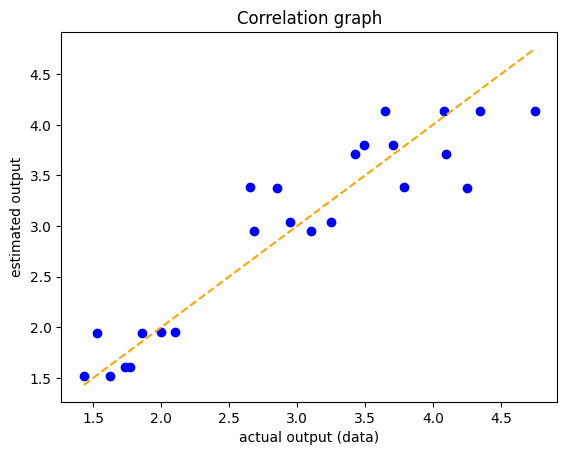

In [ ]:
## display a correlation graph
exec(f"""
def plot_correlation_graph():
    plt.clf()
    plt.plot(output_data, fit_result.eval({auto_generate_function_argument_string()}), 'bo')
    plt.plot([output_data.min(), output_data.max()], [output_data.min(), output_data.max()], color="orange", linestyle="dashed")
    plt.title("Correlation graph")
    plt.xlabel("actual output (data)")
    plt.ylabel("estimated output")
    plt.show()
""")

plot_correlation_graph()


## Bonus: test the predicted value for a specific input

This can be done with the following code:

In [ ]:
# test the expected result for a given input, with:
#print(fit_result.eval(var_a=5, var_b=6, var_c=12))